# Определение возраста покупателей

# Содержание <a name="содержание"></a>
1. [Описание проекта и описание данных](#описание)
2. [Исследовательский анализ](#анализ)
3. [Обучение модели](#обучение)
4. [Вывод](#вывод)

## Описание проекта  <a name="описание"></a>
Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Для решения задачи построили модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста

## Описание данных
Данные взяты с сайта [ChaLearn Looking at People](https://chalearnlap.cvc.uab.es/dataset/26/description/). 


В распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age.

## Исследовательский анализ данных <a name="анализ"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
display(labels.head())
display(labels.shape)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


(7591, 2)

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


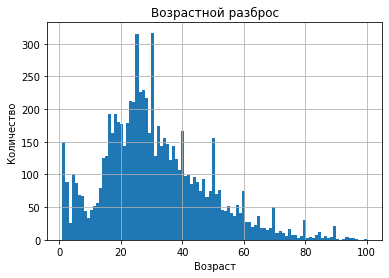

In [4]:
labels.hist(bins=100);
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Возрастной разброс')
plt.show()


In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


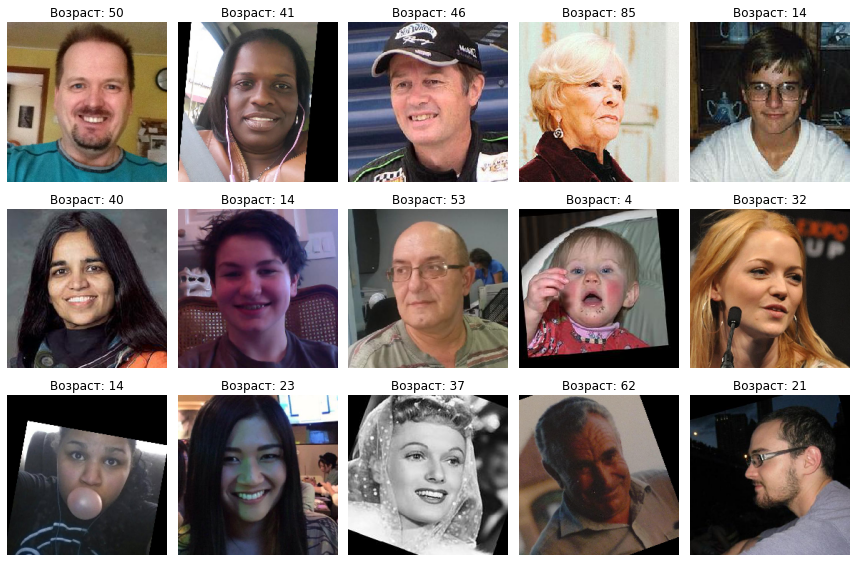

In [6]:
images, labels = train_gen_flow.next()

fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.ravel()

for i in range(15):
    axes[i].imshow(images[i])
    axes[i].set_title(f"Возраст: {labels[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

- В нашем распоряжении датасет на 7591 изображений. 
- Наибольшее количество изображений с возрастом людей находится в периоде от 20 до 40 лет. 
- Пожилых людей, начиная с 60 лет , в датасете становится все меньше.Возможно, модель будет плохо обучаться так как примеров мало. 
- В датасете также присутсвую чернобелые изображения, обрезанные и повернутные влево\вправо.
- Также присуствуют изображения, по которым сложно определить возраст человека, примером служат изображение людей в очках, не смотрящих в камеру, сильное затемнение части изображения). 

## Обучение модели <a name="обучение"></a>

Обучение модели проходило на выделенном сервере, код и результат модели расположен в ячейках markdown.

```python



def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)
    
    model = Sequential()
    model.add(backbone)

    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mae'])


    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

356/356 - 102s - loss: 10.7772 - mae: 10.7711 - val_loss: 22.3245 - val_mae: 22.3231
Epoch 2/10
356/356 - 41s - loss: 7.6028 - mae: 7.6029 - val_loss: 9.5104 - val_mae: 9.4974
Epoch 3/10
356/356 - 41s - loss: 6.5596 - mae: 6.5596 - val_loss: 6.8091 - val_mae: 6.8012
Epoch 4/10
356/356 - 42s - loss: 5.9115 - mae: 5.9117 - val_loss: 6.3973 - val_mae: 6.3986
Epoch 5/10
356/356 - 41s - loss: 5.4883 - mae: 5.4881 - val_loss: 6.7981 - val_mae: 6.7979
Epoch 6/10
356/356 - 41s - loss: 5.0461 - mae: 5.0460 - val_loss: 6.2476 - val_mae: 6.2534
Epoch 7/10
Epoch 8/10
356/356 - 41s - loss: 4.5324 - mae: 4.5323 - val_loss: 6.8589 - val_mae: 6.8555
356/356 - 43s - loss: 4.3245 - mae: 4.3245 - val_loss: 6.1702 - val_mae: 6.1706
Epoch 9/10
356/356 - 41s - loss: 3.9714 - mae: 3.9716 - val_loss: 6.1267 - val_mae: 6.1233
Epoch 10/10
356/356 - 41s - loss: 3.7699 - mae: 3.7700 - val_loss: 6.3594 - val_mae: 6.3644
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 6.3594 - mae: 6.3644
Test MAE: 6.3644

```

## Вывод <a name="вывод"></a>

Модель на основе ResNet50 показала среднюю абсолютную ошибку (MAE) 6.36 года при определении возраста по фотографии. Данный показатель приемлем для целей текущего проекта проекта.

[Оглавление](#содержание)

